# Import Modules 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import nums_from_string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from statistics import mode, median
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization

# Load Target Values

In [3]:
def get_redshifts(filelist, number_of_images = 57720):
    num_string = nums_from_string.get_nums(filelist[0])
    if len(num_string) == 2:
        z = np.array(num_string[1])
    if len(num_string) == 3:
        z = np.array(num_string[1]*10**(num_string[2]))
    for i in np.arange(1,number_of_images):
        num_string = nums_from_string.get_nums(filelist[i])
        if len(num_string) == 2:
            z = np.append(z, num_string[1])
        if len(num_string) == 3:
            z = np.append(z, num_string[1]*10**(num_string[2]))
    return z

In [189]:
filelist = glob.glob("sdss_images/*.jpg")
all_redshifts = get_redshifts(filelist, len(filelist))

Let's make a summary of the target spectroscopic redshifts. We'll tabulate the total number of values as well as the minimum and maximum values. From there, we'll make a histogram.

In [190]:
min_redshift = np.amin(all_redshifts)
max_redshift = np.amax(all_redshifts)
redshift_mean = np.mean(all_redshifts)
redshift_median = np.median(all_redshifts)
redshift_mode = mode(all_redshifts)
print('The number of galaxies is ' + str(len(redshifts)))
print('The smallest redshift is ' + str(min_redshift))
print('The largest redshift is ' + str(max_redshift))
print('The average redshift is ' + str(redshift_mean))
print('The median redshift is ' + str(redshift_median))
print('The most common redshift is ' + str(common_redshift))

The number of galaxies is 1000
The smallest redshift is 1.4759e-07
The largest redshift is 1.97916
The average redshift is 0.3111022324495103
The median redshift is 0.281784
The most common redshift is 0.131643


| Feature            | Value                          |
|--------------------|--------------------------------|
| Number of galaxies | $$57720$$                      |
| Minimum redshift   | $$1.47\times 10^{-7}$$         |
| Maximum redshift   | $$1.98$$                       |
| Average redshift   | $$0.31$$                       |
| Median redshift    | $$0.28$$                       |
| Mode of redshifts  | $$0.13$$                       |

We'll want to space our redshifts in 0.01 intervals, so use this to define the number of bins in the histogram

NameError: name 'all_redshifts' is not defined

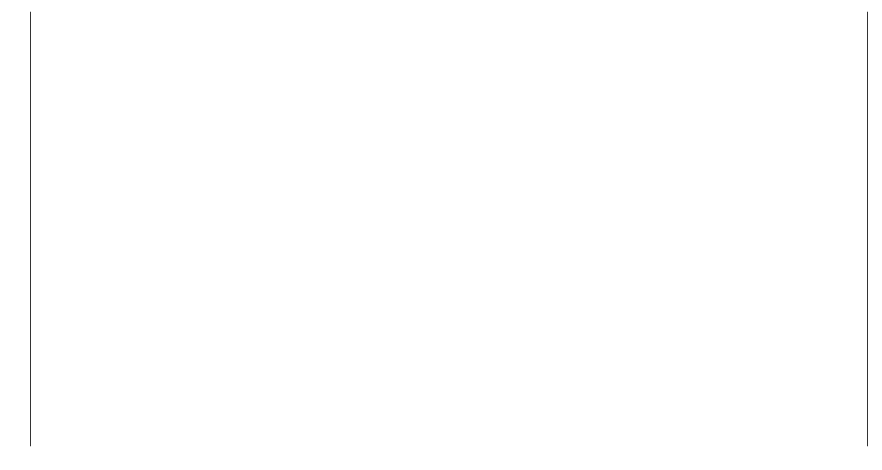

In [4]:
n_bins = 198 # this value is chosen so that bin spacing is 0.01
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

n, bins, patches = plt.hist(all_redshifts, 94, facecolor='orange', alpha=0.5)
plt.xlabel('Galaxy redshift (bin width = 0.01)')
plt.ylabel('Frequency')
plt.title('Distribution of spectroscopic redshifts from SDSS (N = 57720)'.format(n_bins), color = 'white')
plt.show()

# Load images 

In [109]:
def get_images(filelist, number_of_images = 57720):
    _ = np.expand_dims(mpimg.imread(filelist[0]).astype(float), axis = 0)
    jpgs = _

    for i in filelist[1:number_of_images]:

        _ = np.expand_dims(mpimg.imread(i), axis = 0)
        jpgs = np.concatenate((jpgs, _))
    return jpgs

The dataset is *huge,* so for now let's only load 1000 images.
It might be a good idea to come back and optimize this function.

In [154]:
thousand_galaxies = get_images(filelist,1000)

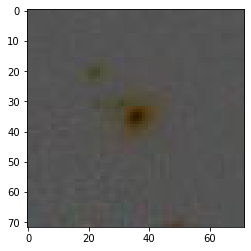

In [156]:
plt.figure()
plt.imshow(thousand_galaxies[11].astype('uint8'))
plt.grid(False)
plt.show()

Let's plot a whole bunch of galaxies to have something to show our friends.

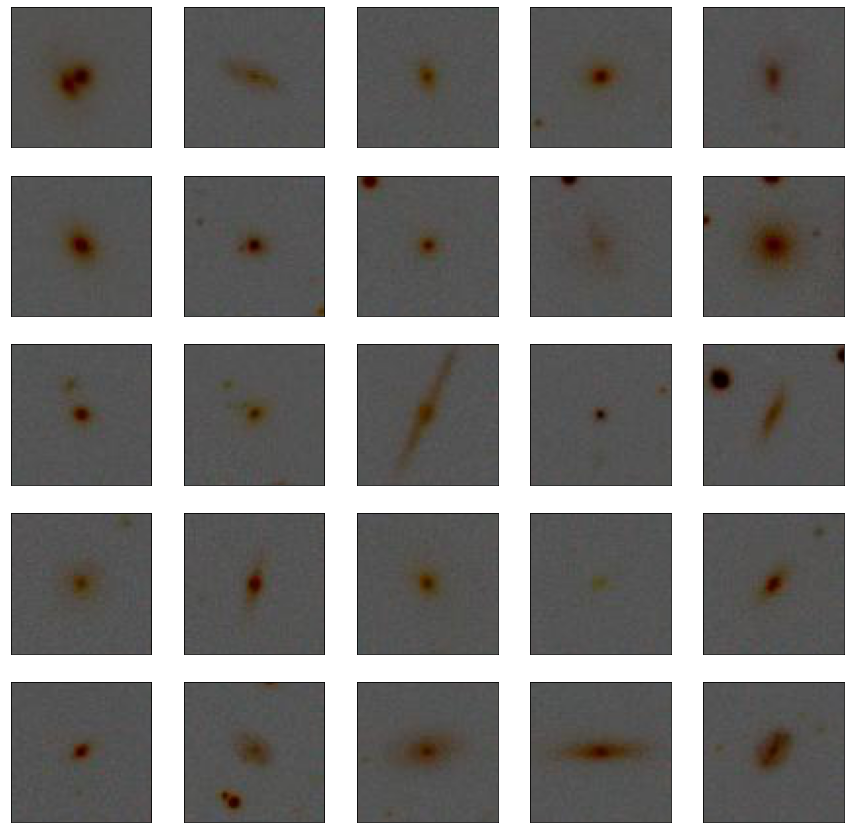

In [157]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(thousand_galaxies[i].astype('uint8'))
plt.show()

Each galaxy is composed of 3 filters: $u$, $g$, and $r$.

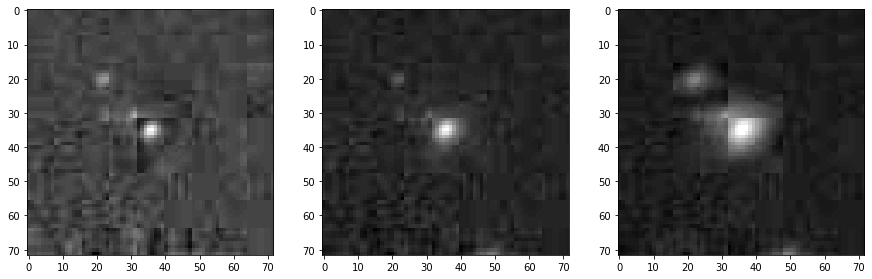

In [158]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(thousand_galaxies[11][:,:,0], cmap=plt.cm.binary)
plt.subplot(1,3,2)
plt.imshow(thousand_galaxies[11][:,:,1], cmap=plt.cm.binary)
plt.subplot(1,3,3)
plt.imshow(thousand_galaxies[11][:,:,2], cmap=plt.cm.binary)
plt.grid(False)
plt.show()

# Pre-processing data 

## Image differences
maybe not essential, so don't implement

## Rescaling

In [159]:
def rescaling(data):
    scaled_data = data
    for i in np.arange(len(data)):
        scaled_data[i] = np.amax(scaled_data[i]) - scaled_data[i]
        scaled_data[i] = scaled_data[i] / np.amax(scaled_data[i])
    return scaled_data

In [160]:
scaled_galaxies = rescaling(thousand_galaxies)

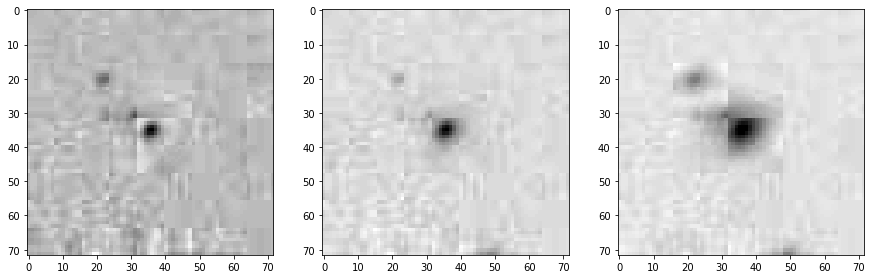

In [164]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(scaled_galaxies[11][:,:,0], cmap=plt.cm.binary)
plt.subplot(1,3,2)
plt.imshow(scaled_galaxies[11][:,:,1], cmap=plt.cm.binary)
plt.subplot(1,3,3)
plt.imshow(scaled_galaxies[11][:,:,2], cmap=plt.cm.binary)
plt.grid(False)
plt.show()

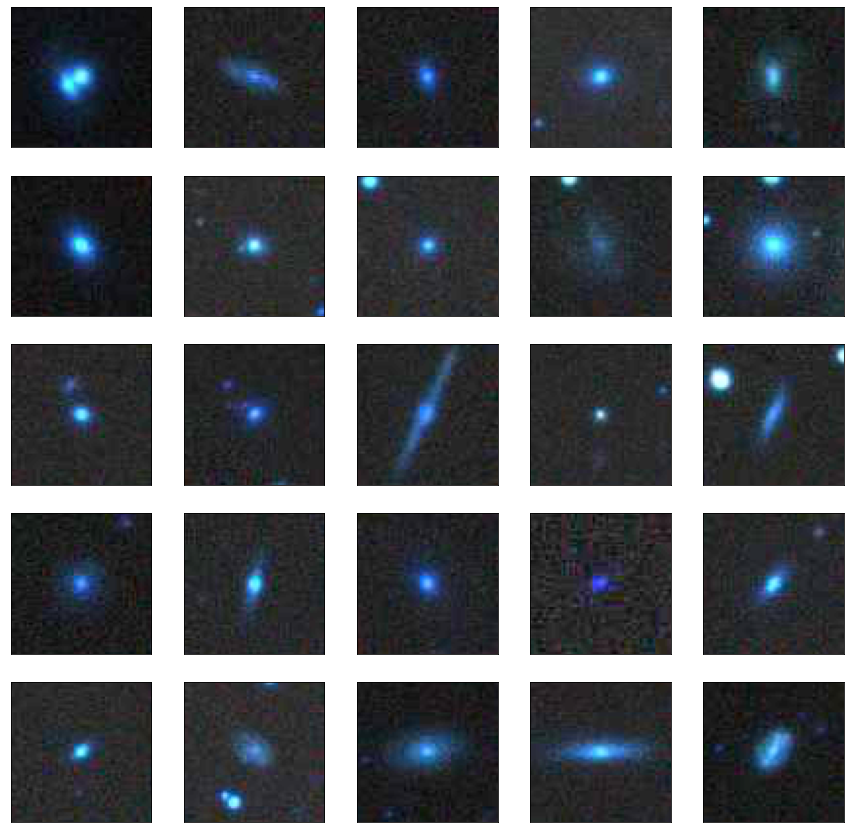

In [165]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(scaled_galaxies[i])
plt.show()

Note: rescaling changes the input dataset *permanently*

## Cropping

In [222]:
def random_crop(a, width = 60):
    m = width/2
    n = 72 - width/2
    b = np.zeros((len(a), width, width, 3))
    for i in np.arange(len(b)):
        z = np.random.randint(m,n)
        x = int(z-width/2)
        y = int(z+width/2)
        b[i] = a[i,x:y,x:y,:]
    return b
# Note that this function is hard-coded!

In [225]:
cropped_galaxies= random_crop(scaled_galaxies)

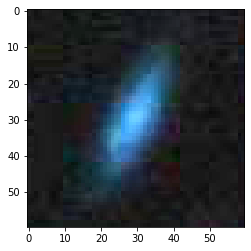

In [228]:
plt.figure()
plt.imshow(cropped_galaxies[27])
plt.grid(False)
plt.show()

In [242]:
# Test that it works
cropped_galaxies.shape == (len(thousand_galaxies), 60, 60, 3)

True

## Train/Test Splitting

Following Hoyle 2016, we'll split the data as follows:

* training set: 0.51%
* validation set: 0.07%
* testing set: 0.42%

We **won't** touch the test set until the hyperparameters of the model have been optimized.
Of course, this very split could very well be regarded as a hyperparameter on its own.

In [170]:
# hard-code these values
train_ratio = 0.51
val_ratio = 0.07
test_ratio = 0.42
# check they add up to one
train_ratio + val_ratio + test_ratio == 1.0

True

In [229]:
# crop redshifts
redshifts = all_redshifts[0:len(scaled_galaxies)]
len(scaled_galaxies) == len(redshifts)

True

In [230]:
# shuffle is set to on by default
train_galaxies, test_galaxies, train_redshifts, test_redshifts = train_test_split(cropped_galaxies, redshifts, train_size=(train_ratio + val_ratio))
train_galaxies, val_galaxies, train_redshifts, val_redshifts = train_test_split(train_galaxies, train_redshifts, train_size=train_ratio/(train_ratio + val_ratio))

In [231]:
len(train_galaxies) + len(val_galaxies) + len(test_galaxies) == len(scaled_galaxies)

True

# Convolutional Deep Neural Network 

In [252]:
redshift_classes = list(np.linspace(0., max_redshift, n_bins))

In [253]:
len(redshift_classes) == n_bins

True

def createHoyleModel():
    model = Sequential()
    # how do I choose the right filter size? Is it the three colors I have? Hoyle uses 4 for RGBA...
    # is the window size just the size of an image? Or the 3x3 of the sub-image?
    # how do I specify the number of sub-images to generate? It should be 10
    # the rectified linear layer is passed into activation, so no need to make a separate layer
    model.add(Conv2D(n_filters, (win_size, win_size), padding='same', activation='relu', input_shape=input_shape))
    # should the max pooling have the 3x3 from the filtered sub-image?
    model.add(MaxPooling2D(pool_size=(smth, smth)))
    # there is no "local renormalization layer" in Keras.
    # Use BatchNormalization because LayerNormalization apparently fails for CNN
    # what about the five neighbor neurons?
    model.add(BatchNormalization())
    # The next convolution layer is 5,256 so maybe 5x5 window and producing 256 images
    model.add(Conv2D(n_filters, (win_size, win_size)))
    model.add(MaxPooling2D(pool_size=(smth, smth)))
    model.add(BatchNormalization())
    # The next convolution layer is 3,384 so maybe 3x3 window and producing 384 images
    model.add(Conv2D(n_filters, (win_size, win_size), activation='relu'))
    # This is repeated
    model.add(Conv2D(n_filters, (win_size, win_size), activation='relu'))
    # Then comes a 3,256 convolution layer
    model.add(Conv2D(n_filters, (win_size, win_size), activation='relu'))
    model.add(MaxPooling2D(pool_size=(smth, smth)))
    # Now we flatten!
    model.add(Flatten())
    # Next comes a fully connected layer. Hoyle uses 4906, which I infer is (60+4)**2
    # That is the full feature space, so we probably have (60+3)**2
    # At this point we have a normal neural net, so we use a dense layer
    model.add(Dense(3969, activation='relu'))
    # Now comes the dropout layer
    model.add(Dropout(0.6))
    # Repeat the full connection
    model.add(Dense(3969, activation='relu'))
    model.add(Dropout(0.6))
    # This last layer is super important. It's a softmax layer with the number of bin
    model.add(Dense(redshift_classes, activation='softmax'))
    return model

In [377]:
def createHoyleModel():
    model = Sequential()
    model.add(Conv2D(10, (3, 3), padding='same', activation='relu', input_shape=(60,60,3)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(384, (3, 3), activation='relu'))
    model.add(Conv2D(384, (3, 3), activation='relu'))
#    these two layers causes negative dimension size    
#    model.add(Conv2D(256, (3, 3), activation='relu'))
#    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten())
    model.add(Dense(3969, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(3969, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(len(redshift_classes), activation='softmax'))
    return model

In [378]:
# Instantiate the model
hoyle_model = createHoyleModel()
# Keep these defaults
hoyle_model.compile(optimizer='rmsprop',
                    loss='mse',
             #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [379]:
# Make a summary
hoyle_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 60, 60, 10)        280       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 20, 20, 10)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 20, 20, 10)        40        
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 16, 16, 256)       64256     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 3, 3, 384)       

## 1000 galaxies, 5 epochs

In [290]:
# Train the model
batch_size = 32 # for lack of a better choice
# epochs = 100 # also a hyperparameter, but Hoyle says he ran it 100 times.
num_epochs = 5
hoyle_model.fit(train_galaxies, train_redshifts, epochs=num_epochs,
              validation_data=(val_galaxies, val_redshifts))

Epoch 1/5
16/16 [==============================] - 54s 3s/step - loss: 0.0315 - accuracy: 0.0000e+00 - val_loss: 0.0529 - val_accuracy: 0.0000e+00
Epoch 2/5
16/16 [==============================] - 56s 3s/step - loss: 0.0315 - accuracy: 0.0000e+00 - val_loss: 0.0529 - val_accuracy: 0.0000e+00
Epoch 3/5
16/16 [==============================] - 55s 3s/step - loss: 0.0315 - accuracy: 0.0000e+00 - val_loss: 0.0529 - val_accuracy: 0.0000e+00
Epoch 4/5
16/16 [==============================] - 58s 4s/step - loss: 0.0315 - accuracy: 0.0000e+00 - val_loss: 0.0529 - val_accuracy: 0.0000e+00
Epoch 5/5
16/16 [==============================] - 56s 3s/step - loss: 0.0315 - accuracy: 0.0000e+00 - val_loss: 0.0529 - val_accuracy: 0.0000e+00


In [ ]:
# Make predictions

In [293]:
# Evaluate how the fully trained model works.
hoyle_model.evaluate(test_galaxies, test_redshifts)

14/14 [==============================] - 13s 904ms/step - loss: 0.0294 - accuracy: 0.0000e+00


[0.02939232811331749, 0.0]

GiGo

In [392]:
# retrain with binary cross entropy as loss

In [390]:
# Train the model
batch_size = 32 # for lack of a better choice
# epochs = 100 # also a hyperparameter, but Hoyle says he ran it 100 times.
num_epochs = 5
hoyle_model.fit(train_galaxies, train_redshifts, epochs=num_epochs,
              validation_data=(val_galaxies, val_redshifts))

Epoch 1/5
80/80 [==============================] - 114s 1s/step - loss: 0.7974 - accuracy: 0.0000e+00 - val_loss: 0.7751 - val_accuracy: 0.0000e+00
Epoch 2/5
80/80 [==============================] - 117s 1s/step - loss: 0.7973 - accuracy: 0.0000e+00 - val_loss: 0.7751 - val_accuracy: 0.0000e+00
Epoch 3/5
80/80 [==============================] - 111s 1s/step - loss: 0.7973 - accuracy: 0.0000e+00 - val_loss: 0.7751 - val_accuracy: 0.0000e+00
Epoch 4/5
80/80 [==============================] - 111s 1s/step - loss: 0.7973 - accuracy: 0.0000e+00 - val_loss: 0.7751 - val_accuracy: 0.0000e+00
Epoch 5/5
80/80 [==============================] - 110s 1s/step - loss: 0.7973 - accuracy: 0.0000e+00 - val_loss: 0.7751 - val_accuracy: 0.0000e+00


In [394]:
hoyle_model.evaluate(test_galaxies, test_redshifts)

66/66 [==============================] - 27s 407ms/step - loss: 0.7887 - accuracy: 0.0000e+00


[0.7887343168258667, 0.0]

In [395]:
hoyle_model.metrics_names

['loss', 'accuracy']

In [419]:
# retrain with categorical cross entropy
# Instantiate the model
hoyle_model = createHoyleModel()
hoyle_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy",
),
             metrics=['accuracy'])

In [421]:
# Train the model
batch_size = 32 # for lack of a better choice
# epochs = 100 # also a hyperparameter, but Hoyle says he ran it 100 times.
num_epochs = 5
hoyle_model.fit(train_galaxies, train_redshifts, epochs=num_epochs,
              validation_data=(val_galaxies, val_redshifts))

Epoch 1/5


ValueError: in user code:

    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\Sebastian\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 198) are incompatible


In [405]:
val_redshifts.shape

(351,)

# Debugging 

In [349]:
threehundred_galaxies = get_images(filelist,300)
scaled_galaxies = rescaling(threehundred_galaxies)
cropped_galaxies= random_crop(scaled_galaxies)
redshifts = all_redshifts[0:len(scaled_galaxies)]
train_galaxies, test_galaxies, train_redshifts, test_redshifts = train_test_split(cropped_galaxies, redshifts, train_size=(train_ratio + val_ratio))
train_galaxies, val_galaxies, train_redshifts, val_redshifts = train_test_split(train_galaxies, train_redshifts, train_size=train_ratio/(train_ratio + val_ratio))

In [319]:
# Instantiate the model
hoyle_model = createHoyleModel()
# Keep these defaults
hoyle_model.compile(optimizer='rmsprop',
                    loss='mse',
             #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

## 300 galaxies, 50 epochs

In [316]:
# Train the model
batch_size = 32 # for lack of a better choice
# epochs = 100 # also a hyperparameter, but Hoyle says he ran it 100 times.
num_epochs = 50
hoyle_model.fit(train_galaxies, train_redshifts, epochs=num_epochs,
              validation_data=(val_galaxies, val_redshifts))

Epoch 1/50
5/5 [==============================] - 7s 1s/step - loss: 0.0274 - accuracy: 0.0000e+00 - val_loss: 0.0426 - val_accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 0.0274 - accuracy: 0.0000e+00 - val_loss: 0.0426 - val_accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.0274 - accuracy: 0.0000e+00 - val_loss: 0.0426 - val_accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.0274 - accuracy: 0.0000e+00 - val_loss: 0.0426 - val_accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 0.0274 - accuracy: 0.0000e+00 - val_loss: 0.0426 - val_accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 0.0274 - accuracy: 0.0000e+00 - val_loss: 0.0426 - val_accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 0.0274 - accuracy: 0.0000e+00 - val_loss: 0.0426 - val_accura

KeyboardInterrupt: 

### 5000 galaxies, 10 epochs 

In [380]:
fivethousand_galaxies = get_images(filelist,5000)
scaled_galaxies = rescaling(fivethousand_galaxies)
cropped_galaxies= random_crop(scaled_galaxies)
redshifts = all_redshifts[0:len(scaled_galaxies)]
train_galaxies, test_galaxies, train_redshifts, test_redshifts = train_test_split(cropped_galaxies, redshifts, train_size=(train_ratio + val_ratio))
train_galaxies, val_galaxies, train_redshifts, val_redshifts = train_test_split(train_galaxies, train_redshifts, train_size=train_ratio/(train_ratio + val_ratio))

#### Binary Cross Entropy 

In [388]:
# Instantiate the model
hoyle_model = createHoyleModel()
# Keep these defaults
hoyle_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"),
             metrics=['accuracy'])

In [381]:
num_epochs = 10
hoyle_model.fit(train_galaxies, train_redshifts, epochs=num_epochs,
              validation_data=(val_galaxies, val_redshifts))

Epoch 1/10
80/80 [==============================] - 124s 2s/step - loss: 0.0362 - accuracy: 0.0000e+00 - val_loss: 0.0329 - val_accuracy: 0.0000e+00
Epoch 2/10
80/80 [==============================] - 125s 2s/step - loss: 0.0362 - accuracy: 0.0000e+00 - val_loss: 0.0329 - val_accuracy: 0.0000e+00
Epoch 3/10
80/80 [==============================] - 127s 2s/step - loss: 0.0362 - accuracy: 0.0000e+00 - val_loss: 0.0329 - val_accuracy: 0.0000e+00
Epoch 4/10
80/80 [==============================] - 119s 1s/step - loss: 0.0362 - accuracy: 0.0000e+00 - val_loss: 0.0329 - val_accuracy: 0.0000e+00
Epoch 5/10
80/80 [==============================] - 128s 2s/step - loss: 0.0362 - accuracy: 0.0000e+00 - val_loss: 0.0329 - val_accuracy: 0.0000e+00
Epoch 6/10
80/80 [==============================] - 125s 2s/step - loss: 0.0362 - accuracy: 0.0000e+00 - val_loss: 0.0329 - val_accuracy: 0.0000e+00
Epoch 7/10
80/80 [==============================] - 119s 1s/step - loss: 0.0362 - accuracy: 0.0000e+00 - v

In [382]:
hoyle_model.evaluate(val_galaxies, val_redshifts)

11/11 [==============================] - 4s 384ms/step - loss: 0.0329 - accuracy: 0.0000e+00


[0.03289599344134331, 0.0]

In [383]:
hoyle_model.evaluate(test_galaxies, test_redshifts)

66/66 [==============================] - 27s 409ms/step - loss: 0.0352 - accuracy: 0.0000e+00


[0.035224247723817825, 0.0]

In [384]:
hoyle_model.predict(test_galaxies)

array([[0.00504854, 0.00504956, 0.00504524, ..., 0.00505488, 0.0050531 ,
        0.00504804],
       [0.00504631, 0.00508377, 0.00498437, ..., 0.005072  , 0.00503572,
        0.00508263],
       [0.00504854, 0.00504956, 0.00504524, ..., 0.00505488, 0.0050531 ,
        0.00504804],
       ...,
       [0.00504854, 0.00504956, 0.00504524, ..., 0.00505488, 0.0050531 ,
        0.00504804],
       [0.00504854, 0.00504956, 0.00504524, ..., 0.00505488, 0.0050531 ,
        0.00504804],
       [0.00504854, 0.00504956, 0.00504524, ..., 0.00505488, 0.0050531 ,
        0.00504804]], dtype=float32)

In [411]:
hoyle_binen_predictions = hoyle_model.predict(val_galaxies)

In [414]:
# This is the shape for the first prediction. Recall that predictions are pdfs!
hoyle_binen_predictions[0].shape

(198,)

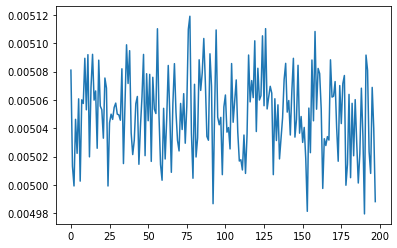

In [433]:
plt.plot(hoyle_binen_predictions[0])

In [431]:
len(hoyle_binen_predictions[0])

198

In [422]:
np.sum(hoyle_binen_predictions[0])

1.0000001

In [423]:
# Okay, so at least I am getting a pdf at the end.

In [424]:
np.max(hoyle_binen_predictions[0])

0.0051190457

In [427]:
val_redshifts[0]

0.367707

In [434]:
np.argmax(hoyle_binen_predictions[0])

77

In [435]:
# This means that the wrong bin is being assigned the highest probability

#### Mean-Squared Error 

In [438]:
# Instantiate the model
hoyle_model2 = createHoyleModel()
# Keep these defaults
hoyle_model2.compile(optimizer='adam', loss='mse',
             metrics=['accuracy'])


In [440]:
num_epochs = 5
hoyle_model2.fit(train_galaxies, train_redshifts, epochs=num_epochs,
              validation_data=(val_galaxies, val_redshifts))

Epoch 1/5
80/80 [==============================] - 114s 1s/step - loss: 0.0362 - accuracy: 0.0000e+00 - val_loss: 0.0329 - val_accuracy: 0.0000e+00
Epoch 2/5
80/80 [==============================] - 123s 2s/step - loss: 0.0362 - accuracy: 0.0000e+00 - val_loss: 0.0329 - val_accuracy: 0.0000e+00
Epoch 3/5
80/80 [==============================] - 159s 2s/step - loss: 0.0362 - accuracy: 0.0000e+00 - val_loss: 0.0329 - val_accuracy: 0.0000e+00
Epoch 4/5
80/80 [==============================] - 138s 2s/step - loss: 0.0362 - accuracy: 0.0000e+00 - val_loss: 0.0329 - val_accuracy: 0.0000e+00
Epoch 5/5
80/80 [==============================] - 138s 2s/step - loss: 0.0362 - accuracy: 0.0000e+00 - val_loss: 0.0329 - val_accuracy: 0.0000e+00


### Try a simpler architecture

In [442]:
def createScrapModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(60, (3, 3), padding='same', activation='relu', input_shape=(60,60,3)))
    model.add(Conv2D(60, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(120, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(120, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(120, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(120, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(redshift_classes), activation='softmax'))
    
    return model

In [441]:
scrap_model = createScrapModel()
scrap_model.compile(optimizer='rmsprop',
                    loss='mse', metrics=['accuracy'])

In [443]:
batch_size = 32
num_epochs = 50
scrap_model.fit(train_galaxies, train_redshifts, epochs=num_epochs,
              validation_data=(val_galaxies, val_redshifts))

Epoch 1/50
 1/80 [..............................] - ETA: 0s - loss: 0.0236 - accuracy: 0.0000e+00

KeyboardInterrupt: 

# MLPRegressor

In [337]:
def reshape(a, width):
    length = len(a)
    return np.reshape(a, (length,(width**2)*3))

In [350]:
train_galaxies = reshape(train_galaxies, 60)

In [351]:
train_galaxies.shape

(152, 10800)

In [352]:
train_redshifts.shape

(152,)

In [364]:
regr = MLPRegressor(random_state=1, max_iter=2000).fit(train_galaxies, train_redshifts)

In [356]:
val_galaxies = reshape(train_galaxies, 60)

In [437]:
regr.predict(val_galaxies)
#regr.predict(np.array([val_galaxies,val_redshifts]))

ValueError: Found array with dim 4. Estimator expected <= 2.

In [367]:
np.mean(val_redshifts)

0.15221420168636365

In [369]:
from sklearn.ensemble import GradientBoostingRegressor

In [370]:
gbr1 = GradientBoostingRegressor(loss = 'huber', criterion='friedman_mse', 
                                 learning_rate = 0.52, max_depth = 14, min_samples_leaf=12, 
                                 min_samples_split=43, n_estimators=77)
gbr1.fit(train_galaxies, train_redshifts)

GradientBoostingRegressor(learning_rate=0.52, loss='huber', max_depth=14,
                          min_samples_leaf=12, min_samples_split=43,
                          n_estimators=77)

### Debugging Summary

1. Implement Hoyle's Network exactly as described. 

Problems here: the library he used doesn't seem to exist anymore, some of the layers described are not available in Keras, the others have really vague descriptions in the paper.

What I tried: Use the closest-looking parameters in Keras I could find.

Results: One layer of convolution and max pooling prevented the network from compiling. I disabled that. Ran code using 1000 galaxies for 10 epochs. Then using 300 galaxies for 50 epochs.

Problem: The loss function doesn't go down.

2. Implement a simpler convolutional network known to succeed at classification

Result: At 300 galaxies, slightly worse loss.

Conclusion from 1 and 2: The network doesn't seem to be learning the labels in the training phase.

3. Implement a multi-layer perceptron for a regression task

Problem: Had to flatten image input at the beginning. Then network runs

Result: Same as the ANN implemented in Keras -- the network tries to train every image to predict a single label.

Meta-problem: waaaaaaay too many parameters to tune:

. Train/val/test split
. Regression or classification layer at end
. Classification bin size
. Number of layers: dense, dropout, convolution, max pooling, normalization
. Convolution and max pooling filters
. Dropout rate
. Optimizer and loss function
. Metric
. Batch size
. Number of epochs

Even if hardcoding as many of these from the referenced as possible (as I did), there are still too many choices left.


In [444]:
# logarithmic bins

In [445]:
# target: make plots a bit more like Brandon's and David's

In [446]:
# confusion matrices?

# Hyperparameter Optimization 

Consider the following

* network architecture: depth, dropouts
* use search algorithm for: number of neurons
* convolution kernels